In [54]:
import numpy as np
import pandas as pd

In [55]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [56]:
class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs,information_gain) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None
        
    def node_leaf(self) -> str:
        if (self.left or self.right):
            return f"NODE | Information Gain = {self.information_gain} | SPLIT IF X[{self.feature_idx}] < {self.feature_val} | Then Left O/W Right"
        else:
            unique_values, value_count = np.unique(self.data[:,-1],return_counts = True)
            output = ", ".join([f"{value}->{count}" for value, count in zip(unique_values, value_count)])
            return f"LEAF | Label counts = {output} | Pred Probs = {self.prediction_probs}"

In [57]:
class DecisionTree():
    def __init__(self, max_depth=4, min_samples_leaf=1, min_information_gain=0.0, numb_of_feature_splitting=None, amount_of_say=None) -> None:
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_the_splitting = numb_of_feature_splitting
        self.amount_of_say = amount_of_say

    def _entropy(self, class_probabilties: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilties if p > 0])

    def _class_probabilities(self, labels: np.array) -> list:
        unique, counts = np.unique(labels, return_counts=True)
        return counts / counts.sum()

    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))

    def _partition_entropy(self, subsets: list) -> float:
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])

    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:
        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]

        return group1, group2

    def _select_feature_to_use(self, data: np.array) -> list:
        feature_idx = list(range(data.shape[1]-1))

        if self.numb_of_the_splitting == "sqrt":
            feature_idx_to_user = np.random.choice(
                feature_idx, size=int(np.sqrt(len(feature_idx)))
            )
        elif self.numb_of_the_splitting == "log":
            feature_idx_to_user = np.random.choice(
                feature_idx, size=int(np.log2(len(feature_idx)))
            )
        else:
            feature_idx_to_user = feature_idx
        return feature_idx_to_user

    def _find_best_split(self, data: np.array) -> tuple:
        min_part_entropy = 1e9
        feature_idx_to_use = self._select_feature_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(
                data[:, idx], q=np.arange(25, 100, 25))

            for feature_val in feature_vals:
                g1, g2 = self._split(data, idx, feature_val)
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy

    def _find_labels_probs(self, data: np.array) -> np.array:
        labels_as_intergers = data[:, -1].astype(int)
        unique, counts = np.unique(labels_as_intergers, return_counts=True)
        label_probability = np.zeros(len(self.labels_in_train), dtype=float)

        label_probability[unique] = counts / counts.sum()

        return label_probability

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        if current_depth > self.max_depth:
            return None

        split_1_data, split_2_data, split_feature_idx, split_feature_vals, split_entropy = self._find_best_split(
            data)

        labels_probabilities = self._find_labels_probs(data)

        node_entropy = self._entropy(labels_probabilities)

        information_gain = node_entropy - split_entropy

        node = TreeNode(data, split_feature_idx, split_feature_vals,
                        labels_probabilities, information_gain)

        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)
        return node

    def _predict_one_sample(self, X: np.array) -> np.array:
        node = self.tree

        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate(
            (X_train, np.reshape(Y_train, (-1, 1))), axis=1
        )
        self.tree = self._create_tree(data=train_data, current_depth=0)

        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        self.feature_importances = {k: v / total for total in (sum(
            self.feature_importances.values()),) for k, v in self.feature_importances.items()}
        
    def predict_proba(self, X_set:np.array)->np.array:
        pred_probs = np.apply_along_axis(self._predict_one_sample,1,X_set)
        return pred_probs
        
    def predict(self, X_set: np.array)-> np.array:
        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)
        return preds
    
    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node != None:
            self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_leaf())
            self._print_recursive(node.right, level + 1)
            
    def print_tree(self)->None:
        self._print_recursive(node=self.tree)
        
    def _calculate_feature_importance(self, node):
        if node != None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)

In [58]:
def train_test_split(X, y, random_state=42, test_size=0.2):
    n_samples = X.shape[0]
    
    np.random.seed(random_state)
    
    shuffled_indices = np.random.permutation(np.arange(n_samples))
    
    test_size = int(n_samples * test_size)
    
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [59]:
X = df.drop("target", axis=1).values
y = df["target"].values

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [61]:
tree = DecisionTree(max_depth=13, min_samples_leaf=1)
tree.train(X_train, y_train)

In [62]:
tree.print_tree()

                                                                                                -> LEAF | Label counts = 1.0->5 | Pred Probs = [0. 1.]
                                                                                -> NODE | Information Gain = 0.0 | SPLIT IF X[0] < 43.0 | Then Left O/W Right
                                                                                                                -> LEAF | Label counts = 1.0->4 | Pred Probs = [0. 1.]
                                                                                                -> NODE | Information Gain = 0.0 | SPLIT IF X[0] < 45.0 | Then Left O/W Right
                                                                                                                                -> LEAF | Label counts = 1.0->3 | Pred Probs = [0. 1.]
                                                                                                                -> NODE | Information Gain = 0.0 | SPLIT IF X[0] < 47.0

In [63]:
train_preds = tree.predict(X_train)
print("PERFORMA TRAIN")
print("Train Size", len(y_train))
print("True preds", sum(train_preds == y_train))
print("Train Accuracy", sum(train_preds == y_train) / len(y_train))

PERFORMA TRAIN
Train Size 820
True preds 820
Train Accuracy 1.0


In [64]:
# Let's see the Test performance
test_preds = tree.predict(X_set=X_test)
print("TEST PERFORMANCE")
print("Test Size", len(y_test))
print("True preds", sum(test_preds == y_test))
print("Test Accuracy", sum(test_preds == y_test) / len(y_test))

TEST PERFORMANCE
Test Size 205
True preds 202
Test Accuracy 0.9853658536585366


## Confusion Matrix

In [65]:
def confusion_matrix(y_true, y_pred, labels = None):
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
        
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    
    for true, pred in zip(y_true, y_pred):
        matrix[label_to_index[true], label_to_index[pred]] += 1
        
    return matrix, labels

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
# Visual Confusion Matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize = (6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Confusion Matrix:
[[102   0]
 [  3 100]]


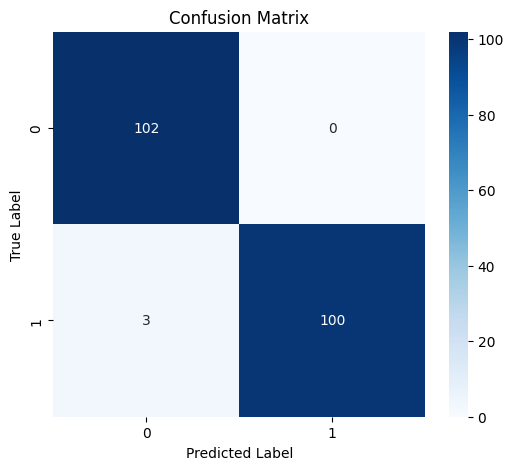

In [68]:
cm, labels = confusion_matrix(y_test, test_preds)
print("Confusion Matrix:")
print(cm)
plot_confusion_matrix(cm, labels)